# Introduction

[Inside Airbnb](http://insideairbnb.com/get-the-data.html) contains publicly available data on listings. The website is independent and not endorsed by Airbnb and is not affiliated with Airbnb's competitors. 
> Airbnb does not have a publicly available database. Inside Airbnb is the closest approximation to the real data from Airbnb. The data files are sourced from the Airbnb web-site and provides the main metrics relevant to examining the performance of Airbnb in major cities around the world

The data used here is based on Airbnb activity in Shanghai. 
>The main purpose here is to pre-process the data, particularly the text data in reviews to provide some interactive visual analysis on the Shanghai data with some additional analysis on pricing. 


In [1]:
# Load the libraries and data files 
import pandas as pd 
import numpy as np
import gzip

import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

with gzip.open('calendar.csv.gz') as C:
     c = pd.read_csv(C)

with gzip.open('listings.csv.gz') as l:
    LD = pd.read_csv(l)

LS = pd.read_csv('SH_listings_summary.csv')
NB = pd.read_csv('SH_neighbourhoods.csv')
RV = pd.read_csv('SH_reviews.csv')

c.head()

C:\Users\ke117\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

C:\Users\ke117\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



listing_id        date available      price adjusted_price  minimum_nights  \
0     1950925  2020-06-21         t  $1,709.00      $1,709.00             1.0   
1       24963  2020-06-21         t    $495.00        $495.00             NaN   
2       24963  2020-06-22         f    $495.00        $495.00             NaN   
3       24963  2020-06-23         f    $495.00        $495.00             3.0   
4       24963  2020-06-24         t    $495.00        $495.00             3.0   

   maximum_nights  
0          1125.0  
1             NaN  
2             NaN  
3           365.0  
4           365.0

### Date, listings, neighbourhood, price

In [2]:
print('Number of unique properties:', c.listing_id.nunique(), 'listings', '&',
      'Number of dates:', c.date.nunique(), 'dates')

print('First and last date:', c.date.min(), '&', c.date.max())

Number of unique properties: 41415 listings & Number of dates: 372 dates
First and last date: 2020-06-20 & 2021-06-26


In [3]:
list(LS)

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [4]:
# rename the listing id column in LS to merge with c id 
LS.rename(columns = {'id':'listing_id'}, inplace = True)

# remove common columns 
LS.drop(columns = {'price',
                   'minimum_nights'}, inplace = True)

# number of unique listings is the same in both LS and c
m1 = pd.merge(c, LS, on = 'listing_id', how = 'left')
m1.listing_id.nunique()

41415

In [78]:
m1.head(1)

listing_id        date available      price adjusted_price  minimum_nights  \
0     1950925  2020-06-21         t  $1,709.00      $1,709.00             1.0   

   maximum_nights                            name   host_id host_name  \
0          1125.0  Selected two bedroom apartment  10044315     Sophy   

   neighbourhood_group           neighbourhood  latitude  longitude  \
0                  NaN  黄浦区 / Huangpu District  31.22776  121.48164   

      room_type  number_of_reviews last_review  reviews_per_month  \
0  Private room                 25  2017-05-29               0.33   

   calculated_host_listings_count  availability_365  
0                               6               365

In [84]:
list(m1)

['listing_id',
 'date',
 'available',
 'price',
 'adjusted_price',
 'minimum_nights',
 'maximum_nights',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [79]:
m1.neighbourhood.value_counts()

浦东新区 / Pudong               5396239
黄浦区 / Huangpu District      2127077
徐汇区 / Xuhui District        1704201
静安区 / Jing'an District      1059513
闵行区 / Minhang District       934568
长宁区 / Changning District     630881
松江区 / Songjiang District     476745
杨浦区 / Yangpu District        476481
虹口区 / Hongkou District       433370
崇明区 / Chongming District     401503
青浦区 / Qingpu District        401160
普陀区 / Putuo District         353755
嘉定区 / Jiading District       294946
宝山区 / Baoshan District       276725
奉贤区 / Fengxian District       86505
金山区 / Jinshan District        65700
Name: neighbourhood, dtype: int64

In [5]:
# Remove the $ sign in price, change to appropriate type (numeric / float)
m1.price = m1.price.str.replace('$', '') # replace with empty space 
m1.price = m1.price.str.replace(',', '')
m1.price = pd.to_numeric(m1.price)

In [40]:
# Convert date object to datetime format 
m1.date = pd.to_datetime(m1.date)

# Extract separately from date
m1['day_of_week'] = pd.DatetimeIndex(m1.date).weekday_name
m1['day_of_month'] = pd.DatetimeIndex(m1.date).day
m1['year'] = pd.DatetimeIndex(m1.date).year
m1['month'] = pd.DatetimeIndex(m1.date).month

In [42]:
m1['day_of_week'].value_counts()

Monday       2169643
Sunday       2164684
Tuesday      2162965
Saturday     2159658
Thursday     2155263
Wednesday    2153578
Friday       2153578
Name: day_of_week, dtype: int64

In [32]:
p = m1.groupby(['month', 'room_type'],
              as_index = False)['price'].mean()

px.scatter(p, 
        x = 'month', y = 'price',
        color = 'room_type',
        trendline = 'lowess')

In [54]:
p = m1.groupby(['day_of_week', 'room_type'],
              as_index = False)['price'].mean()

px.bar(p, 
        x = 'day_of_week', y = 'price',
        color = 'room_type')

In [52]:
p = m1.groupby(['day_of_month', 'room_type'],
              as_index = False)['price'].mean()

px.line(p, 
        x = 'day_of_month',
        y = 'price',
        color = 'room_type')

In [33]:
p = m1.groupby(['month', 'neighbourhood'],
              as_index = False)['price'].mean()

px.scatter(p, 
        x = 'month', y = 'price',
        color = 'neighbourhood',
          trendline = 'lowess')

In [48]:
p = m1.groupby(['day_of_month', 'neighbourhood'],
              as_index = False)['price'].mean()

px.line(p, 
        x = 'day_of_month', y = 'price',
        color = 'neighbourhood')

In [53]:
p = m1.groupby(['day_of_week', 'neighbourhood'],
              as_index = False)['price'].mean()

px.bar(p, 
        x = 'day_of_week', y = 'price',
        color = 'neighbourhood')

In [78]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
        'Saturday', 'Sunday']

w = m1[['day_of_week', 'price']]
# Average price 
w = w.groupby(['day_of_week']).mean().reindex(days)
w = w.reset_index()

px.line(w,
        x = 'day_of_week',
        y = 'price')

In [91]:
months = [1, 2, 3, 4, 5, 6,
          7, 8, 9, 10, 11 , 12]

m = m1[['month', 'price']]

m = m1[['month', 'price']]
m = m.groupby(['month']).mean().reindex(months)
m = m.reset_index()

px.line(m,
        x = 'month',
        y = 'price')

In [105]:
m1.head()

listing_id       date available   price adjusted_price  minimum_nights  \
0     1950925 2020-06-21         t  1709.0      $1,709.00             1.0   
1       24963 2020-06-21         t   495.0        $495.00             NaN   
2       24963 2020-06-22         f   495.0        $495.00             NaN   
3       24963 2020-06-23         f   495.0        $495.00             3.0   
4       24963 2020-06-24         t   495.0        $495.00             3.0   

   maximum_nights                               name   host_id host_name  ...  \
0          1125.0     Selected two bedroom apartment  10044315     Sophy  ...   
1             NaN  Heart of French Concession / Home     98203       Jia  ...   
2             NaN  Heart of French Concession / Home     98203       Jia  ...   
3           365.0  Heart of French Concession / Home     98203       Jia  ...   
4           365.0  Heart of French Concession / Home     98203       Jia  ...   

   number_of_reviews last_review  reviews_per_month  \
0                 25  2017-05-29               0.33   
1                 84  2019-11-22               0.71   
2                 84  2019-11-22               0.71   
3                 84  2019-11-22               0.71   
4                 84  2019-11-22               0.71   

   calculated_host_listings_count availability_365  year month  day  \
0                               6              365  2020     6   21   
1                               2                2  2020     6   21   
2                               2                2  2020     6   22   
3                               2                2  2020     6   23   
4                               2                2  2020     6   24   

   day_of_month  day_of_week  
0            21       Sunday  
1            21       Sunday  
2            22       Monday  
3            23      Tuesday  
4            24    Wednesday  

[5 rows x 25 columns]

In [108]:
m1.price.describe()

count    1.511108e+07
mean     6.248737e+02
std      1.799159e+03
min      0.000000e+00
25%      2.290000e+02
50%      3.580000e+02
75%      5.550000e+02
max      7.066500e+04
Name: price, dtype: float64

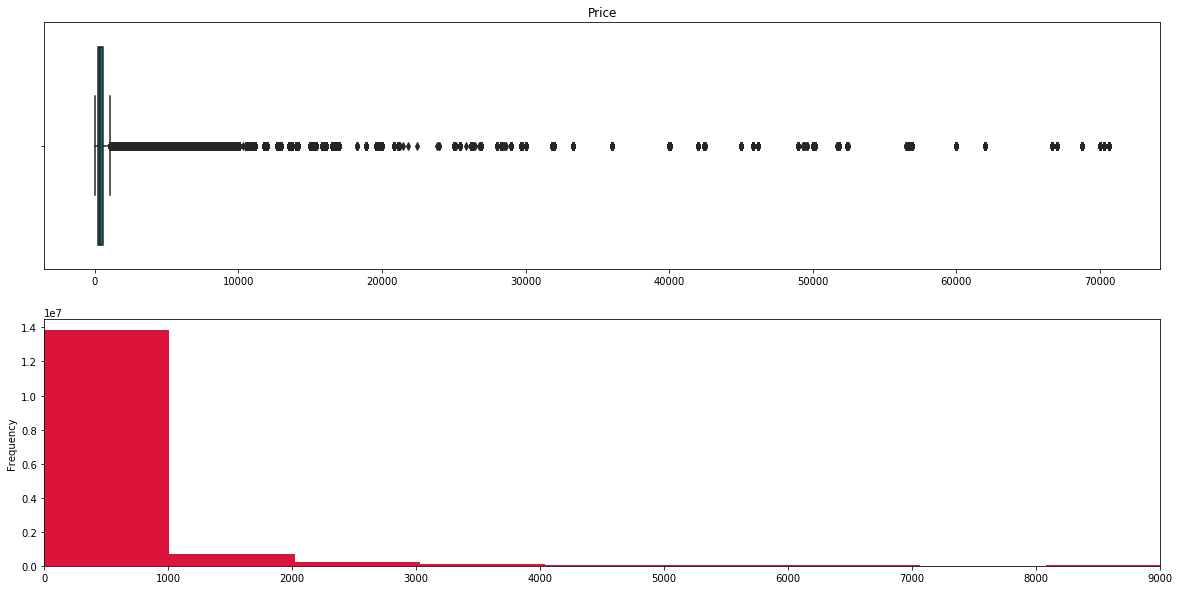

In [109]:
import seaborn as sns 

fig, (ax1, ax2) = plt.subplots(2, 1,
                       figsize = (20, 10))

sns.boxplot([m1['price']],
            ax = ax1,
            color = 'teal').set_title('Price')

m1['price'].plot(kind = 'hist',
                bins = 70,
                xlim = (0, 9000),
                ax = ax2,
                color = 'crimson')

### Listing Availability

In [111]:
m2.available.value_counts()

1    9638760
2    5480609
Name: available, dtype: int64

where t = Available and f = Not available 

In [143]:
m2 = m1[['date', 'available']]

m2['% booked'] = m2['available'].map(lambda x: 0 if x == 't' else 1)

m2 = m2.groupby('date')['% booked'].mean().reset_index()

# % of listings booked 
px.line(m2, 
        x = 'date',
        y = '% booked')

In [146]:
m1.room_type.value_counts()

Entire home/apt    8538959
Private room       6094847
Shared room         483373
Hotel room            2190
Name: room_type, dtype: int64

### Pricing by room type

In [154]:
m3 = m1[['date', 'available', 'room_type']]

m3['% booked'] = m3['available'].map(lambda x: 0 if x == 't' else 1)
m3 = m3.groupby(['date', 'room_type'])['% booked'].mean().reset_index()

px.line(m3, 
           x = 'date',
           y = '% booked',
           color = 'room_type')

### Pricing by property type

In [285]:
LD['price'] = LD['price'].str.replace('$', '')
LD['price'] = LD['price'].str.replace(',', '')
LD['price'] = pd.to_numeric(LD['price'])

LD = LD.loc[LD['price'] < 150000]

#m4 = LD.groupby('property_type', as_index = False)['price'].mean()

px.box(LD, 
       x = 'property_type', y = 'price')

### Pricing by bed
* type
* number of beds

In [286]:
px.box(LD,
       x = 'bed_type',
       y = 'price')

In [288]:
px.box(LD, 
       x = 'beds', y = 'price')

In [289]:
px.histogram(LD, x = 'beds')

### Amenities
- The data is stored in text form 
- Necessary to extract each unique item in the text one by one 

In [195]:
LD.amenities.value_counts()

{TV,Wifi,"Air conditioning",Kitchen,Heating,Washer,Dryer,Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop-friendly workspace","Private entrance"}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### String objects requiring action
* {} is encased within a [] object
* "" also encased within [] (removing [''] now causes an error later) 
* , 

In [217]:
# Replace with empty space
LD['amenities'] = LD['amenities'].str.replace('[{}]', '').str.replace('""','')
LD.amenities.head(1)

0    TV,Wifi,"Air conditioning",Kitchen,"Free parki...
Name: amenities, dtype: object

In [244]:
a1 = pd.Series(np.concatenate(LD['amenities'].map(lambda amn: amn.split(','))))\
.value_counts().head(10)

a1 = pd.DataFrame(a1)
a1.reset_index(inplace = True)
a1.rename(columns = {'index':'amenity', 0:'Count'}, inplace = True)

px.bar(a1, 
       x = 'amenity', y = 'Count',
       color = 'amenity')

In [247]:
m4 = LD[['id', 'price', 'amenities']]
m4['price'] = m4['price'].str.replace('$', '').str.replace(',', '')
m4['price'] = pd.to_numeric(m4['price'])

In [271]:
# Find unique objects after splitting on comma
    # denoted as 'a' in the lambda transform
am_items = np.unique(np.concatenate(m4['amenities'].map(lambda a: a.split(','))))

# Find prices corresponding to unique am_items, exclude empty strings
ap = [(a, 
       m4[m4['amenities'].map(lambda am: a in am)]['price'].mean()) for a in am_items if a !=""]

series = pd.Series(data = [a[1] for a in ap],
                   index = [a[0] for a in ap])

# top 10 
series = series.sort_values(ascending = False)[:10]
series.head()

"Mountain view"      11155.000000
"Outdoor kitchen"     7393.666667
"Fire pit"            5851.000000
"Brick oven"          5761.000000
"Tennis court"        4737.400000
dtype: float64

In [272]:
series = pd.DataFrame(series)
series.reset_index(inplace = True)
series.rename(columns = {'index': 'amenity',
                          0: 'price'}, inplace = True)

series.head()

amenity         price
0    "Mountain view"  11155.000000
1  "Outdoor kitchen"   7393.666667
2         "Fire pit"   5851.000000
3       "Brick oven"   5761.000000
4     "Tennis court"   4737.400000

In [273]:
series.head()

amenity         price
0    "Mountain view"  11155.000000
1  "Outdoor kitchen"   7393.666667
2         "Fire pit"   5851.000000
3       "Brick oven"   5761.000000
4     "Tennis court"   4737.400000

In [275]:
px.bar(series, 
       x = 'amenity',
       y = 'price',
       color = 'amenity')